# Linear regression model: write-up and analysis

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import pandas as pd
import numpy as np

import polars as pl
import datetime
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso

## Setup

In [2]:

__context__ = 'local'

if __context__ == 'local':
    trainDataLocation = '../data/train/'
    from public_timeseries_testing_util import MockApi
    env = MockApi()
    iter_test = env.iter_test()


elif __context__ == 'kaggle':
    trainDataLocation = '/kaggle/input/predict-energy-behavior-of-prosumers/'
    import enefit
    env = enefit.make_env()
    iter_test = env.iter_test()
    !pip install --no-index --no-deps ../input/enefittools/dist/EnefitTools-0.0.45-py3-none-any.whl



In [3]:
# import and format data

from EnefitTools.data import format_dfs

train = pd.read_csv(trainDataLocation+'train.csv')
clients = pd.read_csv(trainDataLocation+'client.csv')


train, clients = format_dfs(train, clients)

## Fold variations in production and consumption suggest a multiplicative model

This model is based on the idea that the daily- and yearly- variations represent fractions of the max output. That is to say, the effect of nights and winter days is to decrease output to a fraction of its output, rather than by a fixed amount.


### Normalizing decreases trajectory variance

In [4]:
working = train.join( 
                     train.group_by(['prediction_unit_id', 'is_consumption']
                                   ).agg(pl.col('target').max().alias('max_value')),
                     on=['prediction_unit_id', 'is_consumption']
                    )
working = working.with_columns( (pl.col('target') / pl.col('max_value')).alias('fraction_of_max'))

working = working.join(clients,left_on=['county', 'is_business', 'product_type', 'date_when_predicting'],
                     right_on=['county', 'is_business', 'product_type', 'date'], how='inner')
working = working.with_columns( (pl.col('target') / pl.col('installed_capacity')).alias('fraction_of_installed') )

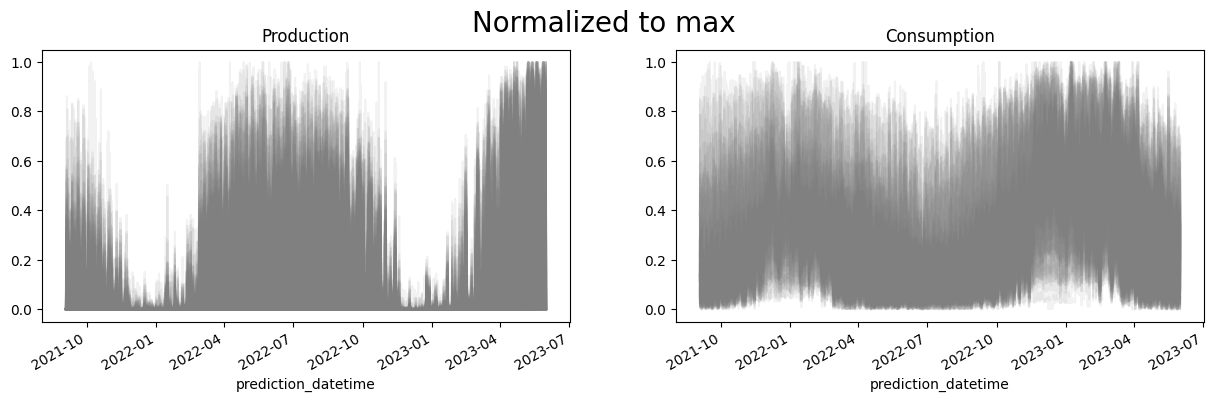

In [5]:
figsize(15,4)
fig, axes = plt.subplots(1,2)

fig.suptitle('Normalized to max', fontsize=20)
axes[0].set_title('Production')
axes[1].set_title('Consumption')

_=working.filter(pl.col('is_consumption') == 0
            ).to_pandas(
            ).pivot(index='prediction_datetime', columns=['prediction_unit_id'], values='fraction_of_max'
            ).plot(legend=False, color='grey', alpha=0.1, ax=axes[0])

_=working.filter(pl.col('is_consumption') == 1
            ).to_pandas(
            ).pivot(index='prediction_datetime', columns=['prediction_unit_id'], values='fraction_of_max'
            ).plot(legend=False, color='grey', alpha=0.1, ax=axes[1])

Normalizing to the maximum value observed really tightens up the consumption curves and production curves. During highly productive seasons, the production is still quite variable (probably due to day-night cycles)

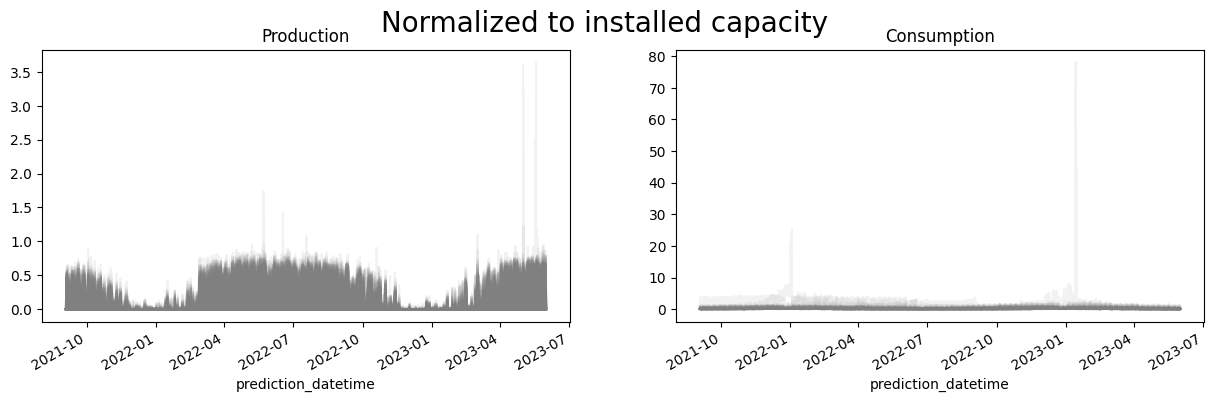

In [6]:
figsize(15,4)
fig, axes = plt.subplots(1,2)

fig.suptitle('Normalized to installed capacity', fontsize=20)
axes[0].set_title('Production')
axes[1].set_title('Consumption')

_= working.filter(pl.col('is_consumption') == 0
            ).to_pandas(
            ).pivot(index='prediction_datetime', columns=['prediction_unit_id'], values='fraction_of_installed'
            ).plot(legend=False, color='grey', alpha=0.1, ax=axes[0])

_= working.filter(pl.col('is_consumption') == 1
            ).to_pandas(
            ).pivot(index='prediction_datetime', columns=['prediction_unit_id'], values='fraction_of_installed'
            ).plot(legend=False, color='grey', alpha=0.1, ax=axes[1])



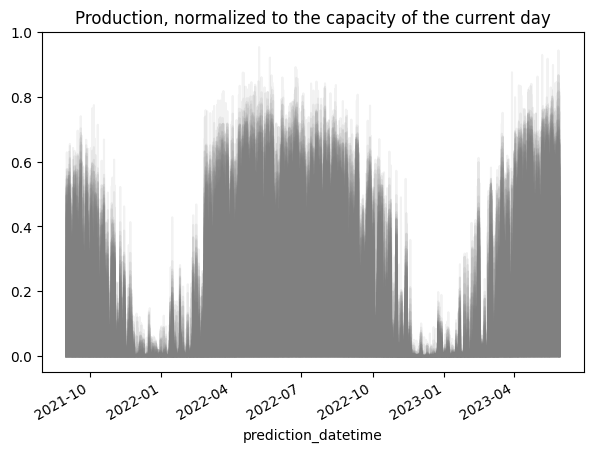

In [7]:
figsize(7,5)

fig, ax = plt.subplots(1,1)

ax.set_title('Production, normalized to the capacity of the current day')

_ = train.with_columns( pl.col('prediction_datetime').dt.date().alias('date_') 
                    ).join(clients,
                           left_on=['county', 'is_business', 'product_type', 'date_'],
                           right_on=['county', 'is_business', 'product_type', 'date'], how='inner'
                    ).filter(pl.col('is_consumption') == 0
                    ).with_columns((pl.col('target') / pl.col('installed_capacity')).alias('capacity_normalized')
                    ).to_pandas(
                    ).pivot(index='prediction_datetime', columns=['prediction_unit_id'], values='capacity_normalized'
                    ).plot(legend=False, color='grey', alpha=0.1, ax=ax)

Normalizing to the installed capacity works less well for both. However, note that, as the second plot shows, production greater than the maxiumum install capacity never occurs. It may appear to occur when forcasting if the installed capacity changes suddenly.

#### 1. normalize to the observed maximum value

In [8]:
# Implementing this

def make_normalization(train):
    """ Preprocess the training features, to find unit-wise max output"""
    max_values = train.group_by(['prediction_unit_id', 'is_consumption']
                     ).agg(max_value=pl.col('target').max())
    return max_values


def normalize_targets(test, max_values):
    """ Map data to training-max normalized data """
    targets = test.drop(['county', 'is_business', 'product_type', 'prediction_datetime',
                        'data_block_id', 'date_when_predicting'
                       ])
    # to improve: better filling of unobserved units
    targets = targets.join(max_values, 
                           on=['prediction_unit_id', 'is_consumption'], how='left'
                ).fill_nan(1.0
                ).with_columns(
                    target=pl.col('target')/pl.col('max_value')
                ).drop(['max_value'])
    return targets


def unnormalize_targets(predictions, max_values):
    predictions = predictions.join(max_values,
                                   on=['prediction_unit_id', 'is_consumption'], how='left'
                            ).with_columns(
                                target=pl.col('target')*pl.col('max_value')
                            ).drop('max_value')
    return predictions


### Are the daily and yearly variances are correlated to the daily / yearly average, respectively?

In [9]:
dailyStats = working.group_by([ 'prediction_unit_id', 'is_consumption', 'date_when_predicting']
                             ).agg(
                                    pl.col('fraction_of_max').mean().alias('daily_mean'),
                                    pl.col('fraction_of_max').std().alias('daily_std')
                               )

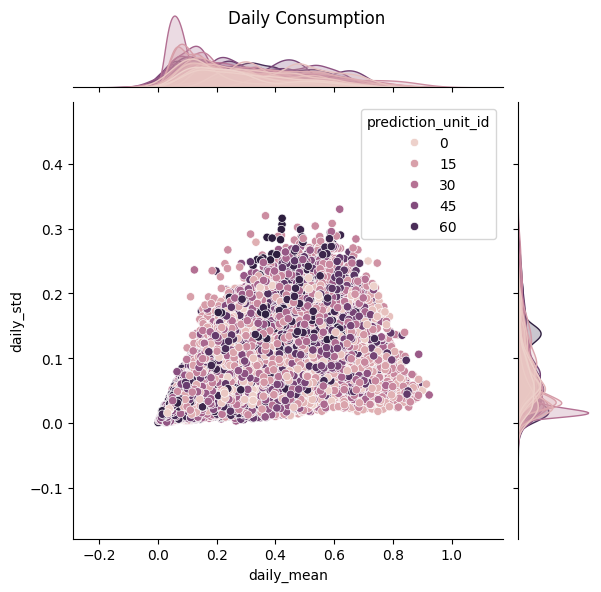

In [10]:
figsize(3,3)

ax = sns.jointplot(data=dailyStats.filter(pl.col('is_consumption')==1), x='daily_mean', y='daily_std', hue='prediction_unit_id')
_=ax.fig.suptitle('Daily Consumption')

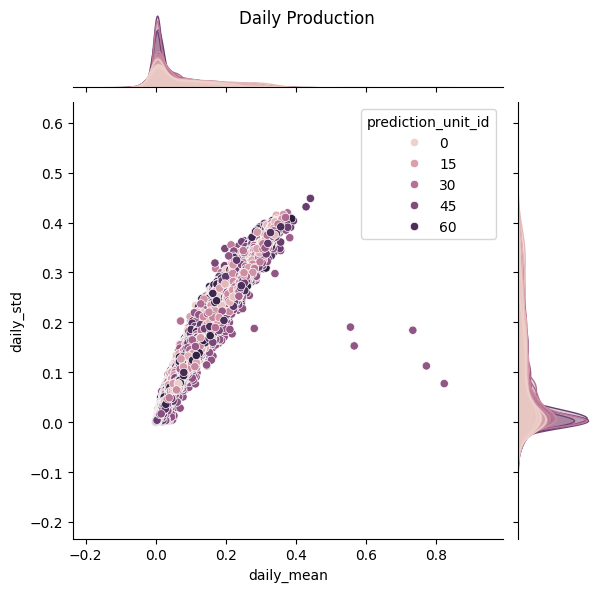

In [11]:
figsize(3,3)

ax = sns.jointplot(data=dailyStats.filter(pl.col('is_consumption')==0), x='daily_mean', y='daily_std', hue='prediction_unit_id')
_=ax.fig.suptitle('Daily Production')

<Axes: title={'center': 'Yearly Production'}, xlabel='mean_of_daily_mean', ylabel='std_of_daily_mean'>

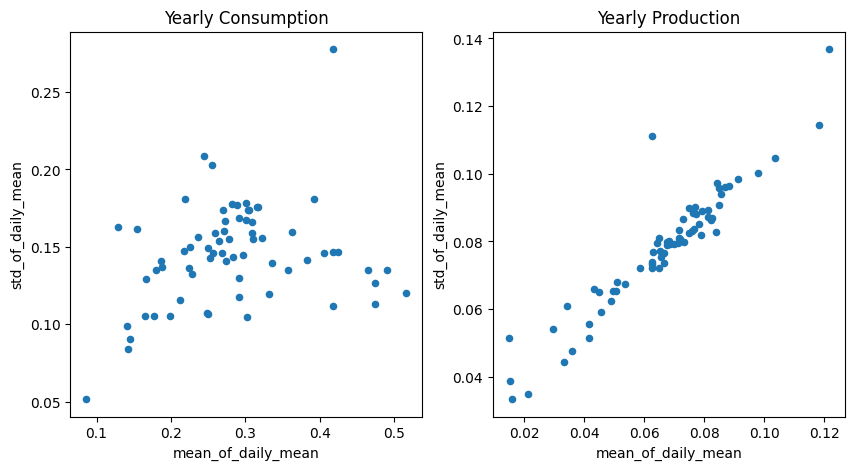

In [12]:
unitStats = dailyStats.group_by(['prediction_unit_id', 'is_consumption']
                     ).agg( mean_of_daily_mean=pl.col('daily_mean').mean(),
                            std_of_daily_mean=pl.col('daily_mean').std()
                          ).to_pandas()
figsize(10, 5)
fig, axes = plt.subplots(1,2)
axes[0].set_title('Yearly Consumption')
unitStats[unitStats.is_consumption == 1].plot(x='mean_of_daily_mean', y='std_of_daily_mean', legend=False, kind='scatter', ax=axes[0])

axes[1].set_title('Yearly Production')
unitStats[unitStats.is_consumption == 0].plot(x='mean_of_daily_mean', y='std_of_daily_mean', legend=False, kind='scatter', ax=axes[1])

I this regard, the production and consumption data look different. For the production, the daily and yearly standard deviation is strongly correlated with the daily / year average production. This indicates that a multiplicative model is appropriate. The effect is much less strong for the consumption data.

#### 2. A multiplicative model is appropriate for production

In [13]:
# implementing this

def log_transform_targets(train):
    """ Preprocess the training features, using log(x+1) transformed targets """
    return train.with_columns( np.log1p(pl.col('target')) )

def undo_log_transform_targets(predictions):
    """ Undo the preprocessing to make the raw features """
    predictions['target'] = np.expm1(predictions['target'] )
    return predictions


In [14]:
del dailyStats, unitStats

## Picking baselines

With multiplicative linear models, it is important to pick a baseline time that avoids what I call a 'faulty-baseline'. We must drop one time-bin to avoid linear dependencies. However, if (eg) the production is close to zero at that time, the remaining coefficients will be forced to be very large to compensate. This problem is even more pronounced if we allow individual regression coefficients for each predicition unit, which I will not do here.

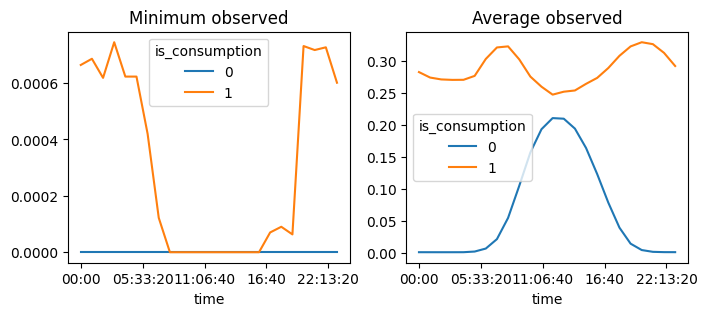

In [15]:
figsize(8,3)
fig, axes = plt.subplots(1,2)

axes[0].set_title('Minimum observed')
axes[1].set_title('Average observed')

_=working.with_columns( pl.col('prediction_datetime').dt.time().alias('time')
                    ).group_by(['is_consumption', 'time']
                    ).agg(min_target=pl.col('fraction_of_max').min()
                    ).to_pandas(
                    ).pivot(index='time', columns='is_consumption', values='min_target').plot(ax=axes[0])


_=working.with_columns( pl.col('prediction_datetime').dt.time().alias('time')
                    ).group_by(['is_consumption', 'time']
                    ).agg(mean_target=pl.col('fraction_of_max').mean()
                    ).to_pandas(
                    ).pivot(index='time', columns='is_consumption', values='mean_target').plot(ax=axes[1])

Here we see:
1. there is no time at which production is always non-zero
2. the average consumption has a higher baseline than production

From this, we can conclude that
1. Something like 6:00 is probably a reasonable baseline time
2. There is more structure to the energy consumption dataset:
    - while the mean production is dominated by the sun-cycle, the consumption patterns don't appear to be
    - eg. businesses may consume more during the day, and non-buisnesses at night. I saw this in my preliminary analysis

<Axes: title={'center': 'Production'}, xlabel='time'>

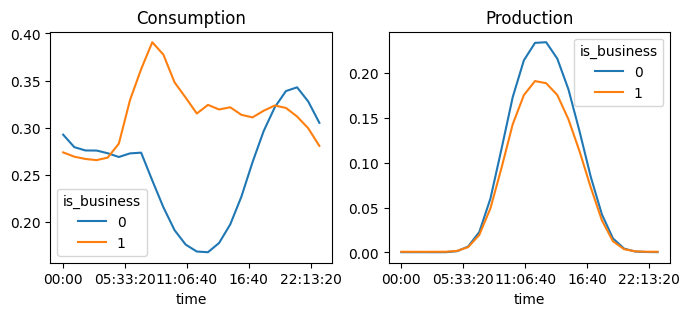

In [16]:
figsize(8,3)
fig, axes = plt.subplots(1,2)

axes[0].set_title('Consumption')
axes[1].set_title('Production')


working.filter(pl.col('is_consumption') == 1).with_columns( pl.col('prediction_datetime').dt.time().alias('time')
                    ).group_by(['time', 'is_business']
                    ).agg(mean_target=pl.col('fraction_of_max').mean()
                    ).to_pandas(
                    ).pivot(index='time', columns='is_business', values='mean_target').plot(ax=axes[0])

working.filter(pl.col('is_consumption') == 0).with_columns( pl.col('prediction_datetime').dt.time().alias('time')
                    ).group_by(['time', 'is_business']
                    ).agg(mean_target=pl.col('fraction_of_max').mean()
                    ).to_pandas(
                    ).pivot(index='time', columns='is_business', values='mean_target').plot(ax=axes[1])

Business is a valuable covariate that interacts with time!

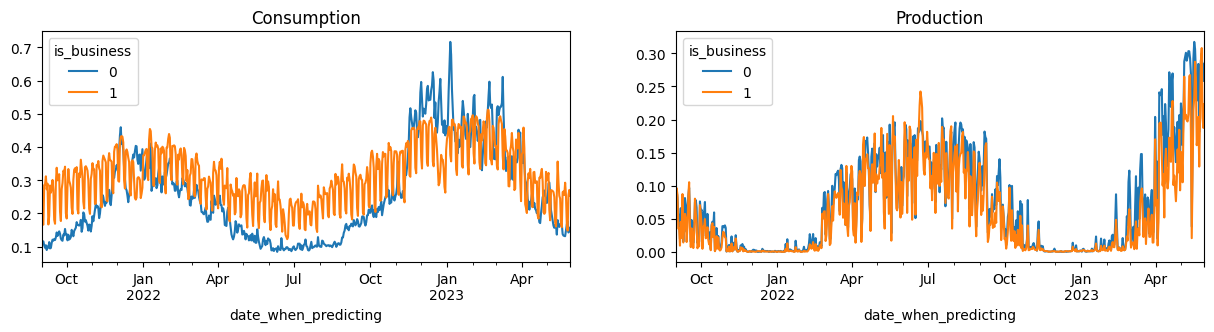

In [17]:
figsize(15,3)
fig, axes = plt.subplots(1,2)

axes[0].set_title('Consumption')
axes[1].set_title('Production')


_=working.filter(pl.col('is_consumption') == 1
                ).group_by(['date_when_predicting', 'is_business']
                ).agg(mean_target=pl.col('fraction_of_max').mean()
                ).to_pandas(
                ).pivot(index='date_when_predicting', columns='is_business', values='mean_target').plot(ax=axes[0])

_=working.filter(pl.col('is_consumption') == 0
                ).group_by(['date_when_predicting', 'is_business']
                ).agg(mean_target=pl.col('fraction_of_max').mean()
                ).to_pandas(
                ).pivot(index='date_when_predicting', columns='is_business', values='mean_target').plot(ax=axes[1])

Once again, the consumption sees different temporal trends, annually and weekly, depending on whether it is a business or not! Production less so.

We also see different time dependencies for the other categories of product type and county

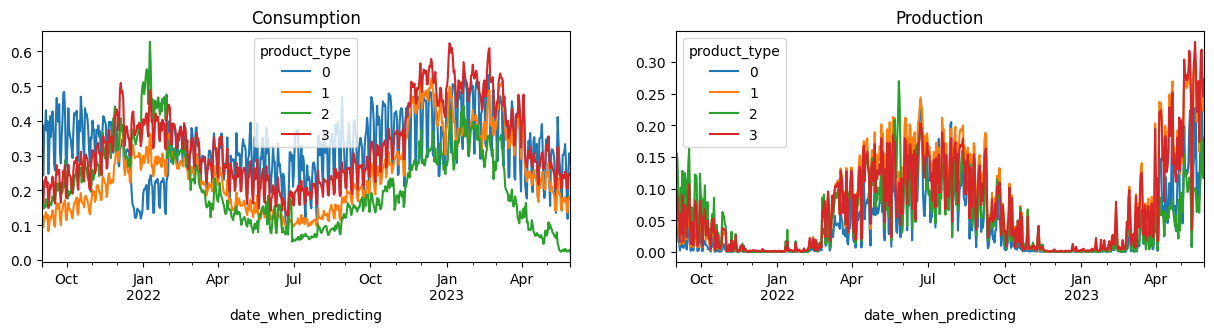

In [18]:
figsize(15,3)
fig, axes = plt.subplots(1,2)

axes[0].set_title('Consumption')
axes[1].set_title('Production')


_=working.filter(pl.col('is_consumption') == 1
                ).group_by(['date_when_predicting', 'product_type']
                ).agg(mean_target=pl.col('fraction_of_max').mean()
                ).to_pandas(
                ).pivot(index='date_when_predicting', columns='product_type', values='mean_target').plot(ax=axes[0])

_=working.filter(pl.col('is_consumption') == 0
                ).group_by(['date_when_predicting', 'product_type']
                ).agg(mean_target=pl.col('fraction_of_max').mean()
                ).to_pandas(
                ).pivot(index='date_when_predicting', columns='product_type', values='mean_target').plot(ax=axes[1])

## Time series PCA

Note that, the differences between different product types above may be due to different prevalences of businesses in different product types, or other underlying causes.
This leads to the question of how best to decompose the trajectories. 

On one hand, we could fit a time series for each different prediction unit, this leads to ~65 different times-series, each fit to only one sample. One the other extreme is what I was doing before: fitting a single time-series to all prediction units. In between is a PCA approach: we decompose the ~65 different time-series units into a smaller number of PCs, and fit the PCs with timeseries, which will then be used for the forecasting.



In [19]:
from sklearn.decomposition import PCA


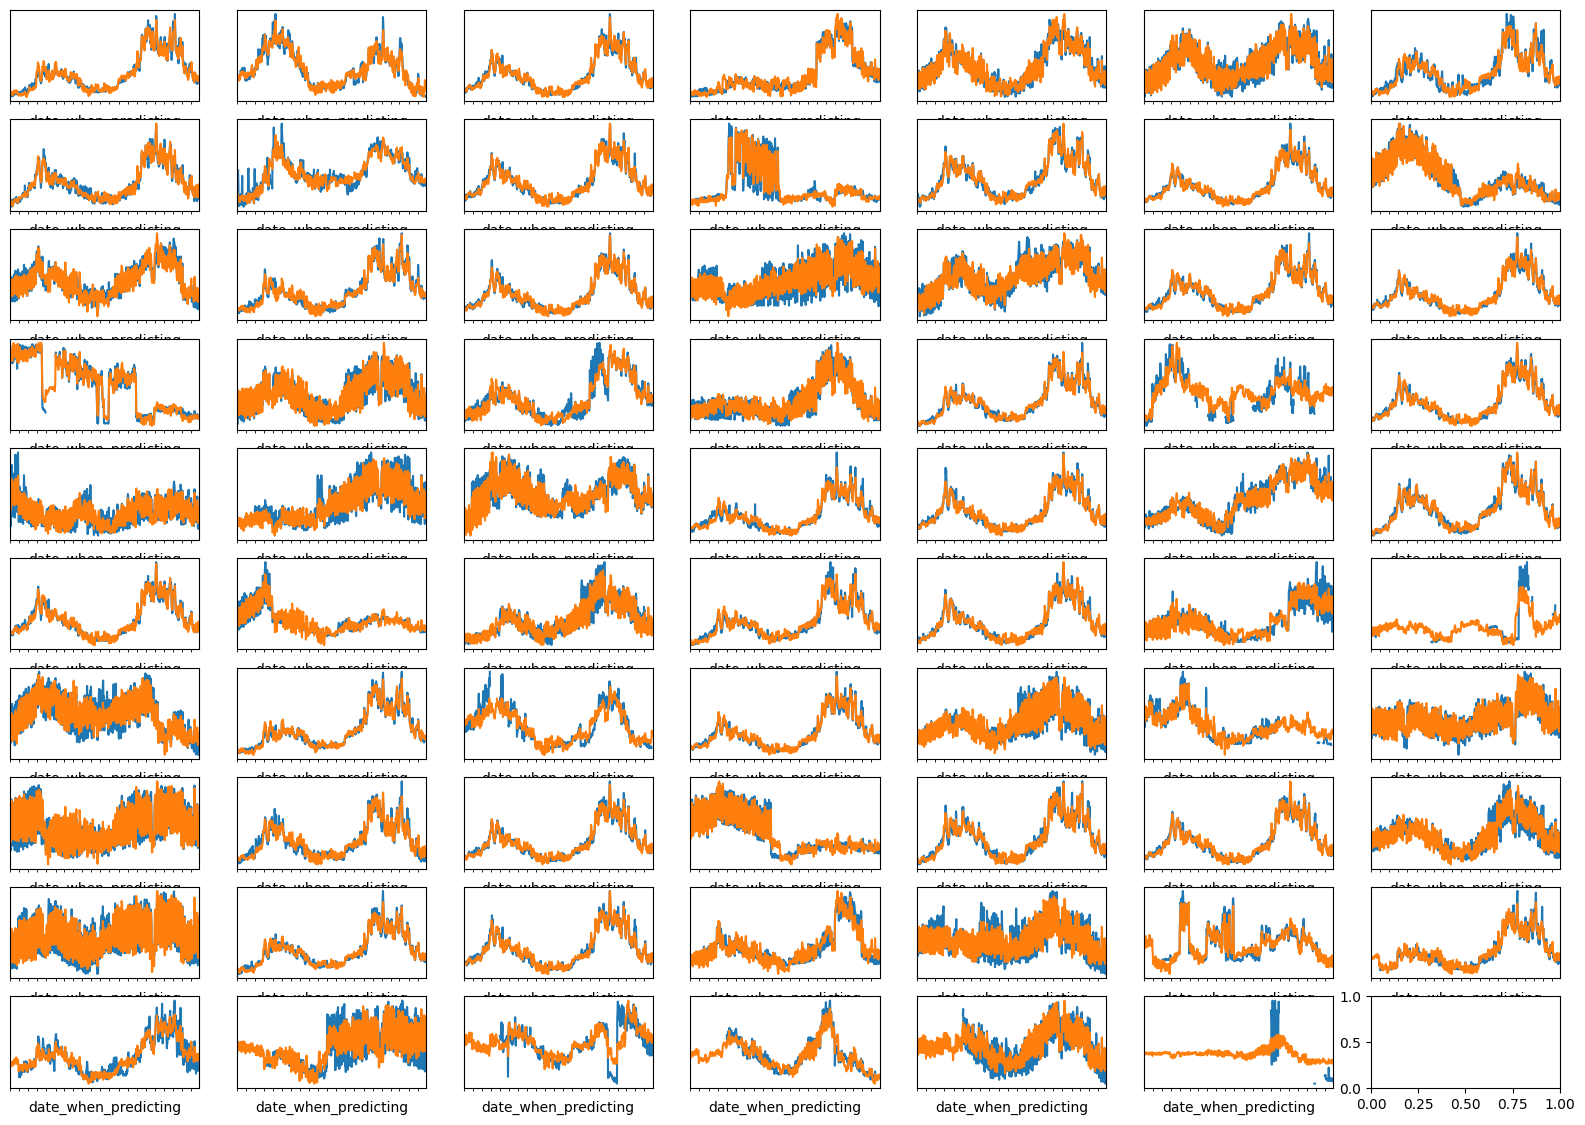

In [20]:
figsize(20,14)

fig, axes = plt.subplots(10,7)
axes = axes.reshape(-1)

groupedByUnit = working.filter(pl.col('is_consumption') == 1
                              ).group_by(['date_when_predicting', 'prediction_unit_id']
                              ).agg(mean_target=pl.col('fraction_of_max').mean()
                              ).to_pandas(
                              ).pivot(index='date_when_predicting', columns='prediction_unit_id', values='mean_target')
groupedByUnit = groupedByUnit - groupedByUnit.mean()

pca = PCA( n_components=10)
pca = pca.fit( groupedByUnit.fillna(0.0).T)

PC_fits = pca.components_.T @ pca.components_ @ groupedByUnit.fillna(0.0)
PC_fits.index = groupedByUnit.index

for i in range(groupedByUnit.columns.shape[0]):
    groupedByUnit[i].plot(ax=axes[i])
    PC_fits[i].plot(ax=axes[i])
    axes[i].set_yticks([])
    axes[i].set_xticks([])


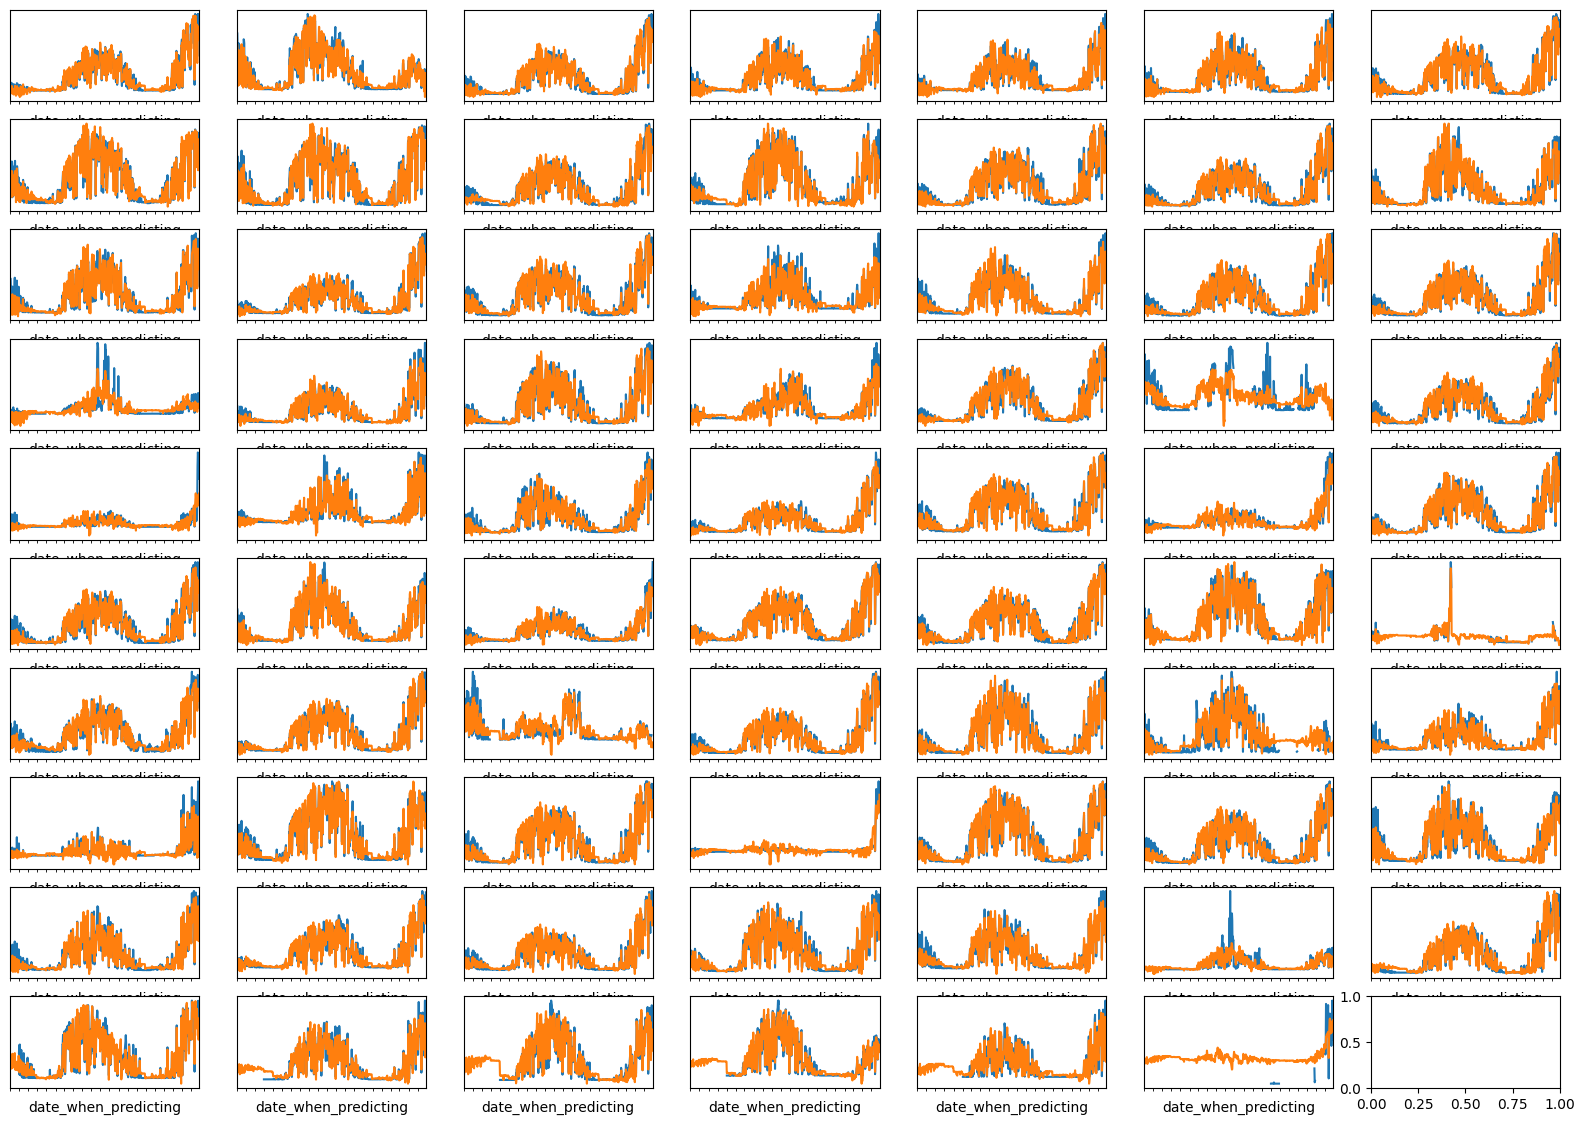

In [21]:
figsize(20,14)

fig, axes = plt.subplots(10,7)
axes = axes.reshape(-1)

groupedByUnit = working.filter(pl.col('is_consumption') == 0
                              ).group_by(['date_when_predicting', 'prediction_unit_id']
                              ).agg(mean_target=pl.col('fraction_of_max').mean()
                              ).to_pandas(
                              ).pivot(index='date_when_predicting', columns='prediction_unit_id', values='mean_target')
groupedByUnit = groupedByUnit - groupedByUnit.mean()

pca = PCA( n_components=10)
pca = pca.fit( groupedByUnit.fillna(0.0).T)

PC_fits = pca.components_.T @ pca.components_ @ groupedByUnit.fillna(0.0)
PC_fits.index = groupedByUnit.index

for i in range(groupedByUnit.columns.shape[0]):
    groupedByUnit[i].plot(ax=axes[i])
    PC_fits[i].plot(ax=axes[i])
    axes[i].set_yticks([])
    axes[i].set_xticks([])

Here, we see that the PCA is good at capturing general slow trends, but struggles with the higher frequency behaviors, in this case probably the weekly effects. It is also clear that there are some prediction units with very sparse data or only very late data, which would gain in predictive power from using other units' data.

#### I'm not convinced that pure PCA faithfully captures time series features

This will need further development and model comparison, but for now, I will use a simple set of predictors.

## Regression Models 

In [22]:
from EnefitTools.data import format_dfs

from EnefitTools.models import make_wrapped_model

from EnefitTools.features.regression_features import make_date_process, make_regression_features
from EnefitTools.features.target_features import LogTransformer, IdNormalizer


from sklearn.pipeline import Pipeline

train = pd.read_csv(trainDataLocation+'train.csv')
clients = pd.read_csv(trainDataLocation+'client.csv')

train, clients = format_dfs(train, clients)

dates = make_date_process(train)
features = make_regression_features( train, clients, dates)

Annoyingly, TransformedTargetRegressor casts its inputs to numpy before using them

In [23]:
from sklearn.compose import TransformedTargetRegressor

from EnefitTools.models import make_wrapped_model
from EnefitTools.features.target_features import LogTransformer, IdNormalizer

normalizeToMax = IdNormalizer()
normalizeToMax = normalizeToMax.fit(train)

# production
def production_fwd (targets): return LogTransformer.fit_transform( normalizeToMax.transform( targets) ) 
def production_inv (targets): return normalizeToMax.inverse_transform( LogTransformer.inverse_transform(targets) )

production_model = make_wrapped_model(LinearRegression)

production_features = features.filter(pl.col('is_consumption') == 0).drop('is_consumption')
production_targets = train.filter(pl.col('is_consumption') == 0).drop('is_consumption')

#consumption 
def consumption_fwd (targets): return normalizeToMax.transform( targets)
def consumption_inv (targets): return normalizeToMax.inverse_transform(targets)

consumption_model = make_wrapped_model(LinearRegression)

consumption_features = features.filter( (pl.col('is_consumption') ==1) ).drop('is_consumption')
consumption_targets = train.filter( (pl.col('is_consumption') == 1) ).drop('is_consumption')



In [24]:
production_model.fit(production_features,  production_fwd( train))
consumption_model.fit(consumption_features, consumption_fwd(train))


In [25]:
for (test, revealed_targets, client, weatherHistorical, weatherForecast,
    electricityPrices, gasPrices, sample_prediction) in iter_test:

    test, client = format_dfs(test, client)
    features = make_regression_features(test, client, dates)

    productionFeatures = features.filter(pl.col('is_consumption') == 0).drop(['is_consumption', 'currently_scored'])
    consumptionFeatures = features.filter(pl.col('is_consumption') == 1).drop(['is_consumption', 'currently_scored'])
    
    productionPredictions = production_inv(production_model.predict( productionFeatures ))
    consumptionPredictions = consumption_inv(consumption_model.predict(consumptionFeatures))

    fullPredictions = pl.concat([productionPredictions, consumptionPredictions], how='vertical').to_pandas()
    prediction = sample_prediction.merge(fullPredictions, on='row_id', how='left', suffixes=['_old', '']
                                        ).drop(columns='target_old').fillna(0.0)
    env.predict(prediction)